In [13]:
import numpy as np

experiment_configs = [{"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_local"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [0]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_1d"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [0]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [1]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [1]}]
def get(key, arr):
    return np.asarray([dict_el[key] for dict_el in arr])

In [14]:
import os
import pprint
import pandas as pd

def load_experiments():
    #experiment_dir = "experiment." + network_config
    results_lift = None
    i = 0
    for experiment_dir in filter(
        lambda x: os.path.isdir(os.path.join(".", x)) and 
        x.startswith("experiment.") and 
        os.path.isdir(os.path.join(".", x, "results_lift")), 
        os.listdir(".")):
        results_lift_dir = os.path.join(".", experiment_dir, "results_lift")

        for filename in os.listdir(results_lift_dir):
            single_csv = pd.read_csv(os.path.join(results_lift_dir, filename), index_col=False)
            single_csv["datetime"] = filename[:filename.find("_")]
            single_csv["n_neurons_l0"] = int(experiment_dir[15:experiment_dir.find("-", 15)])
            if results_lift is not None:
                results_lift = results_lift.append(single_csv, ignore_index=True)                
            else:
                results_lift = single_csv
            i = i + 1
            if i % 20 == 0:
                print(".", end="")
    print()
    return results_lift

def matches(result, config):
    for (key, allowed_values) in config.items():
        if key in result and (
            (isinstance(result[key], float) and result[key] in allowed_values) or
            (isinstance(result[key], str) and result[key] in 
                 [value.replace("\x00","") for value in allowed_values])):
            next
        else:
            return False
    return True

def filter_experiments(experiment_configs, nonfiltered_results):
    results = []
    for config in experiment_configs:
        results.append(nonfiltered_results[np.all([
                        nonfiltered_results[k].isin(vs) for k, vs in config.items()], axis=0)])
        #results.append([result for result in nonfiltered_results if matches(result, config)])
    return results

nonfiltered_results = load_experiments()

results = filter_experiments(experiment_configs, nonfiltered_results)
data_is_reset = True
print("%d non-filtered results." % len(nonfiltered_results))
#pp.pprint(nonfiltered_results)
print("%d filtered results for experiment 0:" % len(results[0]))
print(results[0][0:2])

print("Loaded " + str(len(results)) + " experiment(s):")
for exp_i in range(len(results)):
    print("Experiment " + str(exp_i) + ": " + str(len(results[exp_i])) + " records")
    
# results_folded = []
# for exp_i in range(len(results)):
#     ipn = results[exp_i].loc[[0]]["n_inputs"] / results[exp_i].loc[[0]]["layer_len1"]
#     ipnps_l0 = ipn / results["runtime_l0"]
#     ipnps_l1 = ipn / get("runtime_l1", results[exp_i])
#     ipnps_l2 = ipn / get("runtime_l2", results[exp_i])
#     results_folded.append(
#         {"ipnps_mean_l0": np.mean(ipnps_l0),
#          "ipnps_std_l0": np.std(ipnps_l0),
#          "ipnps_mean_l1": np.mean(ipnps_l1),
#          "ipnps_std_l1": np.std(ipnps_l1)})

# pp.pprint(results_folded)

...........................................................................................................................................................................................................................................................................................................
5985 non-filtered results.
920 filtered results for experiment 0:
               device_name                        f_name  n_inputs  \
0  GeForce GTX TITAN Black  f_layer_complex_neuron_local        32   
4  GeForce GTX TITAN Black  f_layer_complex_neuron_local        64   

   mults_per_thread  neurons_per_wrg  layer_len0  layer_len1  layer_len2  \
0                 1                0         512          32          10   
4                 1                0         512          32          10   

  activation_f0 activation_f1 activation_f2  runtime_l0  runtime_l1  \
0          ReLU          ReLU            id    74.76726     2.05613   
4          ReLU          ReLU            id   149.52

In [15]:
# Format data
if data_is_reset:
    # Runtimes: s -> ms
    original_status = pd.options.mode.chained_assignment
    pd.options.mode.chained_assignment = None
    for result in results:
        result.loc[:, "runtime_l0"] = result["runtime_l0"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l1"] = result["runtime_l1"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l2"] = result["runtime_l2"].apply(lambda x: x * 1000)
    pd.options.mode.chained_assignment = original_status
    print ("Data was formatted.")
    data_is_reset = False

Data was formatted.


In [16]:
def ipnps(df):
    if df.empty:
        return 0
    else:
        #return df["runtime_l0"]
        #return df["n_inputs"] / (df["layer_len0"] * df["runtime_l0"])
        #return df["runtime_l0"] / (df["n_inputs"] * df["layer_len0"])
        return (df["n_inputs"] * df["layer_len0"]) / df["runtime_l0"]
    
def standardize(df):
    return (df - df.min()) / (df.max() - df.min())

In [17]:
# Prepares data

matrices = []
n_n_neurons = int(1024 / 32 - 1)
n_n_inputs = int(1056 / 32 - 1)
for experiment in results:
    matrix = np.zeros((n_n_neurons, n_n_inputs), dtype=np.float32)
    for n_neurons in np.arange(n_n_neurons):
        for n_inputs in np.arange(n_n_inputs):
            matrix[n_neurons, n_inputs] = np.nan_to_num(
                experiment[(experiment["layer_len0"] == 32 + n_neurons * 32) &
                           (experiment["n_inputs"] == 32 + n_inputs * 32)]\
                [["n_inputs", "layer_len0", "runtime_l0"]]\
                .apply(ipnps, axis=1).mean())
            #print(".", end="")

    matrix = standardize(matrix)
    print()
    matrix2 = np.zeros((matrix.shape[0] + 1, matrix.shape[1] + 1))
    matrix2[1:, 1:] = matrix[:, :]
    matrix = matrix2#.transpose()
    print("Matrix shape:", matrix.shape)
    print("Data prepared.")
    print(matrix)
    matrices.append(matrix)


Matrix shape: (32, 33)
Data prepared.
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.64859337  0.79063886 ...,  0.80967236  0.80144858
   0.81250119]
 [ 0.          0.86729544  0.871849   ...,  0.87352294  0.85417062
   0.87699562]
 ..., 
 [ 0.          0.84460551  0.87453794 ...,  0.          0.          0.        ]
 [ 0.          0.84515017  0.90247726 ...,  0.          0.          0.        ]
 [ 0.          0.84370232  0.86671412 ...,  0.          0.          0.        ]]

Matrix shape: (32, 33)
Data prepared.
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.35127166  0.3559173  ...,  0.40115964  0.40877232
   0.38608548]
 [ 0.          0.37631765  0.37939876 ...,  0.56234545  0.5129953
   0.49345347]
 ..., 
 [ 0.          0.35771075  0.37469852 ...,  0.          0.          0.        ]
 [ 0.          0.35793516  0.37906671 ...,  0.          0.          0.        ]
 [ 0.          0.357

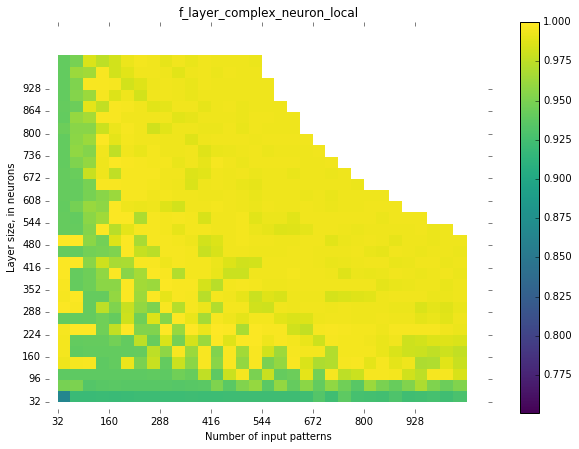

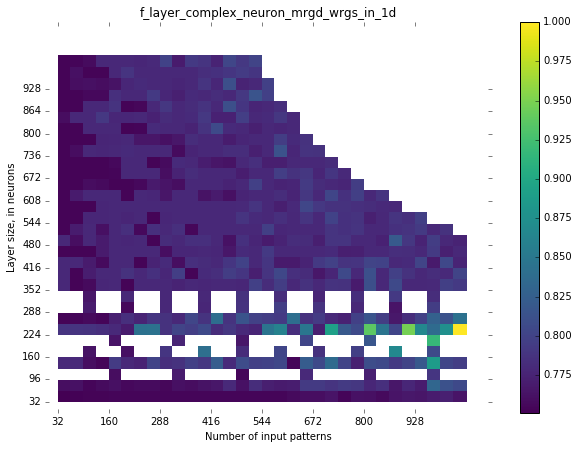

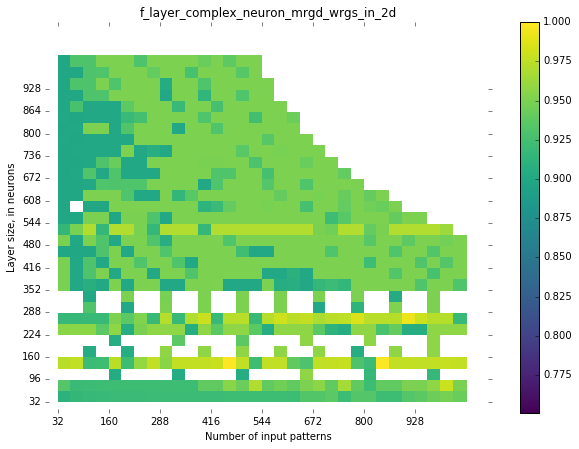

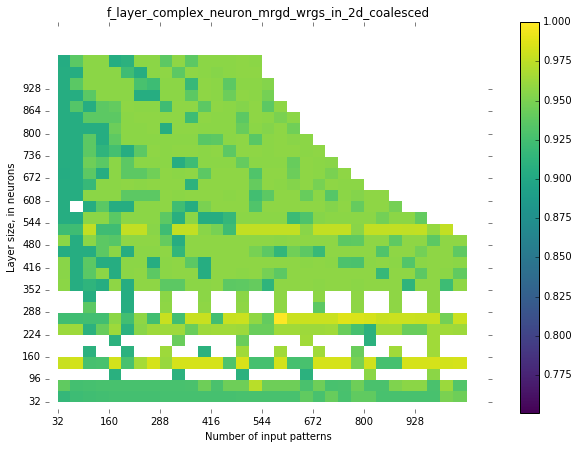

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

second_min_global = 2
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    if second_min < second_min_global:
        second_min_global = second_min
    
i = 0
for matrix in matrices:
    # Renders the plot
    fig, ax = plt.subplots()
    cmap = plt.cm.viridis
    heatmap = ax.pcolor(matrix, cmap=cmap, vmin=second_min_global, vmax=1)
    m = plt.cm.ScalarMappable(cmap=cmap)
    cmap.set_under(color="white")
    m.set_clim(vmin=second_min)
    m.set_array(matrix)
    plt.colorbar(m)

    ax.set_title(experiment_configs[i]["f_name"][0])
    ax.set_xlabel('Number of input patterns')
    ax.set_ylabel('Layer size, in neurons')
    ax.set_xticks(np.arange(1, n_n_inputs, 4))
    ax.set_xticklabels(np.arange(32, 1056, 32 * 4))
    ax.set_yticks(np.arange(1, n_n_neurons, 2))
    ax.set_yticklabels(np.arange(32, 1024, 32 * 2))

    # Format
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    # turn off the frame
    ax.set_frame_on(False)
    i = i + 1